<a href="https://colab.research.google.com/github/GralhaJ/PUC-Rio/blob/main/Gotcha_GPT_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ensure the necessary packages are installed
!pip install scikit-posthocs
!pip install openpyxl --upgrade

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef, cohen_kappa_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
import io
import requests

from scipy.stats import wilcoxon, friedmanchisquare
import scikit_posthocs as sp

In [5]:
def read_excel_from_github(language='english', engine='openpyxl'):
  # Corrigir a URL
  if language == 'english':
      url = 'https://raw.githubusercontent.com/andresilvapimentel/Gotcha-GPT/main/text_classification_eng.xlsx'
  elif language == 'portuguese':
      url = 'https://raw.githubusercontent.com/andresilvapimentel/Gotcha-GPT/main/text_classification_port.xlsx'
  else:
      raise ValueError("Language must be 'english' or 'portuguese'")

  # Solicitar o arquivo
  response = requests.get(url)

  # Verificar se a solicitação foi bem-sucedida
  response.raise_for_status()

  # Ler os dados Excel a partir do conteúdo da resposta
  excel_data = io.BytesIO(response.content)
  df = pd.read_excel(excel_data, engine=engine)

  return df



language = input("Enter language ('english' or 'portuguese'): ").lower()

if language == "english":
    file_url = "https://raw.githubusercontent.com/andresilvapimentel/Gotcha-GPT/main/text_classification_eng.xlsx"
elif language == "portuguese":
    file_url = "https://raw.githubusercontent.com/andresilvapimentel/Gotcha-GPT/main/text_classification_pt.xlsx"
else:
    raise ValueError("Invalid language choice. Please select 'english' or 'portuguese'.")

try:
    df = pd.read_excel(file_url, engine='openpyxl')
except HTTPError as e:
    print(f"Erro ao acessar o arquivo: {e}")


Enter language ('english' or 'portuguese'): english


In [6]:
# Prepare X and y
X = df.drop(columns=['index', 'text', 'AI Metric'])
y = df['AI Metric']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Define classifiers
classifiers = {
    'ExtraTrees': ExtraTreesClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GaussianNB': GaussianNB()
}

# Train and evaluate models
metrics = ['accuracy', 'precision', 'recall', 'f1', 'mcc', 'kappa']
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_proba_train = clf.predict_proba(X_train)[:, 1] if hasattr(clf, "predict_proba") else None
    y_pred_test = clf.predict(X_test)

    # Calculate metrics
    results[name] = {
        'train': {
            'accuracy': accuracy_score(y_train, y_pred_train),
            'precision': precision_score(y_train, y_pred_train),
            'recall': recall_score(y_train, y_pred_train),
            'f1': f1_score(y_train, y_pred_train),
            'mcc': matthews_corrcoef(y_train, y_pred_train),
            'kappa': cohen_kappa_score(y_train, y_pred_train),
            'confusion_matrix': confusion_matrix(y_train, y_pred_train)
        },
        'test': {
            'accuracy': accuracy_score(y_test, y_pred_test),
            'precision': precision_score(y_test, y_pred_test),
            'recall': recall_score(y_test, y_pred_test),
            'f1': f1_score(y_test, y_pred_test),
            'mcc': matthews_corrcoef(y_test, y_pred_test),
            'kappa': cohen_kappa_score(y_test, y_pred_test),
            'confusion_matrix': confusion_matrix(y_test, y_pred_test)
        }
    }

# Selecting the best model based on the average of metrics
train_scores = {name: [results[name]['train'][metric] for metric in metrics] for name in classifiers.keys()}
best_model = max(train_scores, key=lambda x: np.mean(train_scores[x]))

# Predict on the test set with the best model
best_clf = classifiers[best_model]
y_pred_test = best_clf.predict(X_test)
y_proba_test = best_clf.predict_proba(X_test)[:, 1] if hasattr(best_clf, "predict_proba") else None

# Display test metrics and confusion matrix
test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_test),
    'precision': precision_score(y_test, y_pred_test),
    'recall': recall_score(y_test, y_pred_test),
    'f1': f1_score(y_test, y_pred_test),
    'mcc': matthews_corrcoef(y_test, y_pred_test),
    'kappa': cohen_kappa_score(y_test, y_pred_test)
}

In [8]:
# Wilcoxon Rank Sum Test and Friedman Test
friedman_stat, friedman_p = friedmanchisquare(*train_scores.values())

# Restructure data for posthoc_conover
data = []
for classifier, scores in train_scores.items():
    for metric_idx, score in enumerate(scores):
        data.append([classifier, metrics[metric_idx], score])

df_scores_melted = pd.DataFrame(data, columns=['classifier', 'metric', 'score'])

# Pairwise Conover-Friedman Test
posthoc_conover = sp.posthoc_conover(df_scores_melted, val_col='score', group_col='classifier', p_adjust='holm')

# Create a DataFrame for Friedman test results
friedman_results = pd.DataFrame({'Friedman Statistic': [friedman_stat], 'p-value': [friedman_p]})
friedman_results = friedman_results.style.format({'Friedman Statistic': "{:.2f}", 'p-value': "{:.2f}"})

# Format Conover-Friedman test results
posthoc_conover = posthoc_conover.style.format("{:.2f}")

In [9]:
friedman_results

,Friedman Statistic,p-value
0,12.00,0.00


In [10]:
posthoc_conover

,ExtraTrees,GaussianNB,RandomForest
ExtraTrees,1.00,0.00,1.00
GaussianNB,0.00,1.00,0.00
RandomForest,1.00,0.00,1.00


In [11]:
# Assuming 'results' dictionary from your code (containing train metrics)
train_metrics = {model: results[model]['train'] for model in results}

# Create a pandas DataFrame
df_train_metrics = pd.DataFrame(train_metrics).T  # Transpose for better formatting
df_train_metrics.index.name = 'Model'  # Set index name to "Model"
print(f"Training results:")
print(f"Best Model: {best_model} based on training scores")
# Display the DataFrame
df_train_metrics

Training results:
Best Model: ExtraTrees based on training scores


,accuracy,precision,recall,f1,mcc,kappa,confusion_matrix
Model,,,,,,,
ExtraTrees,1.0,1.0,1.0,1.0,1.0,1.0,"[[317, 0], [0, 336]]"
RandomForest,1.0,1.0,1.0,1.0,1.0,1.0,"[[317, 0], [0, 336]]"
GaussianNB,0.992343,0.991098,0.994048,0.992571,0.984676,0.984672,"[[314, 3], [2, 334]]"


In [12]:
# Assuming 'results' dictionary from your code (containing train metrics)
test_metrics = {model: results[model]['test'] for model in results}

# Create a pandas DataFrame
df_test_metrics = pd.DataFrame(test_metrics).T  # Transpose for better formatting
df_test_metrics.index.name = 'Model'  # Set index name to "Model"
print(f"Testing results:")
# Display the DataFrame
df_test_metrics

Testing results:


,accuracy,precision,recall,f1,mcc,kappa,confusion_matrix
Model,,,,,,,
ExtraTrees,0.987805,0.976744,1.0,0.988235,0.975872,0.975581,"[[78, 2], [0, 84]]"
RandomForest,0.969512,0.964706,0.97619,0.970414,0.93904,0.93897,"[[77, 3], [2, 82]]"
GaussianNB,0.97561,0.987805,0.964286,0.975904,0.951503,0.95122,"[[79, 1], [3, 81]]"


In [13]:
# Show prediction and probability for each test sample
train_results = pd.DataFrame({"Prediction": y_pred_train, "Probability of being AI": y_proba_train})
# Format the 'p-value' column to display 2 decimal places
train_results['Probability of being AI'] = train_results['Probability of being AI'].apply(lambda x: '{:.2f}'.format(x))
print("Training Results:")
train_results

Training Results:


,Prediction,Probability of being AI
0,1,0.99
1,0,0.00
2,1,0.99
3,0,0.00
4,1,1.00
...,...,...
648,1,1.00
649,0,0.00
650,1,1.00
651,0,0.00


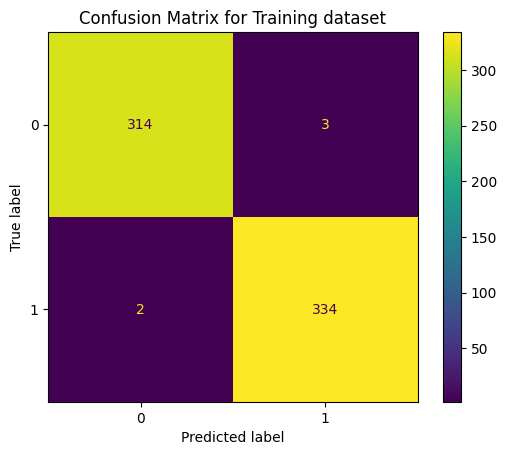

In [14]:
# Create the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Confusion Matrix for Training dataset")
plt.show()

In [15]:
# Show prediction and probability for each test sample
test_results = pd.DataFrame({"Prediction": y_pred_test, "Probability of being AI": y_proba_test})
print("Test Results:")
test_results

Test Results:


,Prediction,Probability of being AI
0,1,1.00
1,1,1.00
2,0,0.00
3,1,0.76
4,0,0.00
...,...,...
159,1,0.91
160,0,0.01
161,0,0.00
162,1,0.98


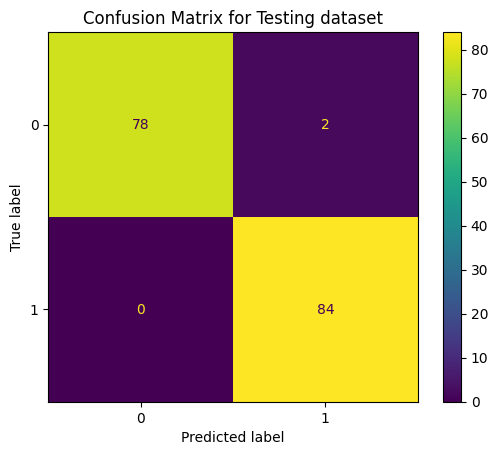

In [16]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Confusion Matrix for Testing dataset")
plt.show()

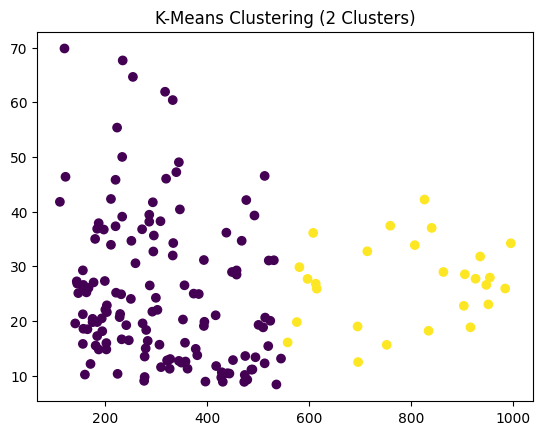

In [17]:
# Perform K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_test)

# Access data using .iloc for numpy-style indexing
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=clusters, cmap='viridis')

plt.title("K-Means Clustering (2 Clusters)")
plt.show()

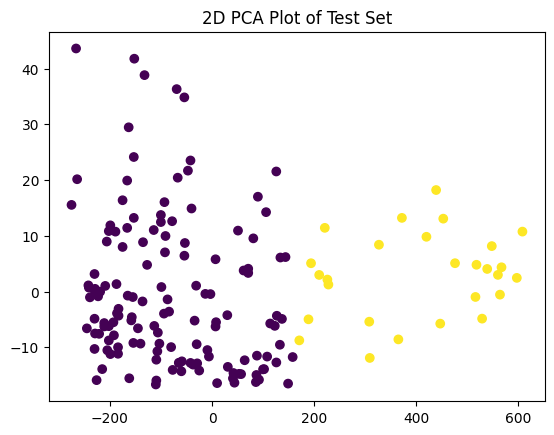

In [18]:
# PCA for 2D visualization
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=clusters, cmap='viridis')
plt.title("2D PCA Plot of Test Set")
plt.show()

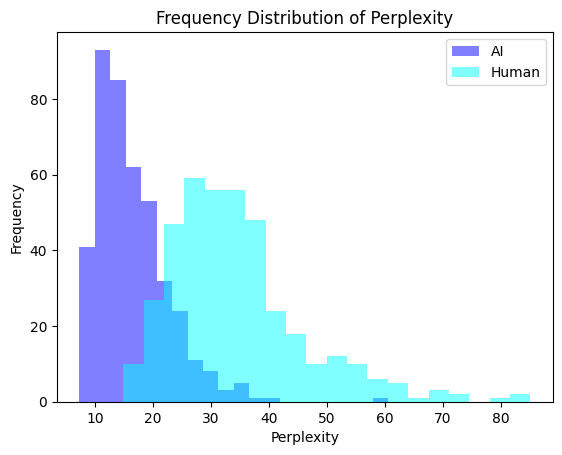

In [19]:
# Extract AI and human class labels
df_Human = df.loc[df['AI Metric'] == 0, 'Perplexity']
df_AI = df.loc[df['AI Metric'] == 1, 'Perplexity']

plt.hist(df_AI, bins=20, stacked=True, color=['blue'], alpha=0.5, label=['AI'])
plt.hist(df_Human, bins=20, stacked=True, color=['cyan'], alpha=0.5, label=['Human'])
plt.legend(loc='upper right')
plt.xlabel('Perplexity')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Perplexity')
plt.show()

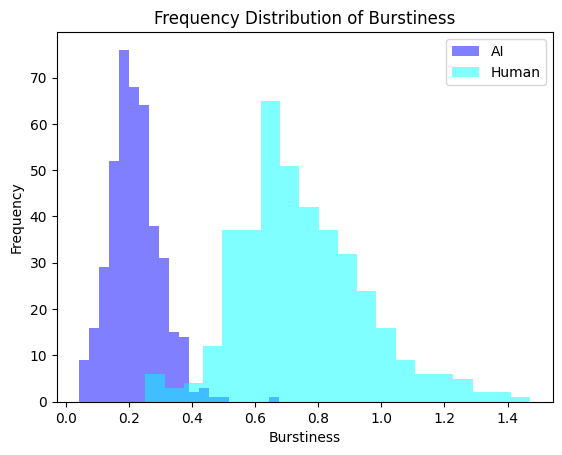

In [20]:
# Extract AI and human class labels
df_Human = df.loc[df['AI Metric'] == 0, 'Burstiness']
df_AI = df.loc[df['AI Metric'] == 1, 'Burstiness']

plt.hist(df_AI, bins=20, stacked=True, color=['blue'], alpha=0.5, label=['AI'])
plt.hist(df_Human, bins=20, stacked=True, color=['cyan'], alpha=0.5, label=['Human'])
plt.legend(loc='upper right')
plt.xlabel('Burstiness')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Burstiness')
plt.show()

In [21]:
# Install required libraries for classifying real texts
!pip install --upgrade docx2txt
!pip install transformers==4.23.0

In [22]:
import docx2txt
import numpy as np
import torch
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


0it [00:00, ?it/s]

In [23]:
# Step 4: Upload the DOCX file of real texts to be check for plagiarism using AI
from google.colab import files
uploaded = files.upload()
filenames = uploaded.keys()
lista_texts = list(filenames)
lista_texts

Saving abstract_human_20.docx to abstract_human_20.docx


['abstract_human_20.docx']

In [24]:
# Step #1: Function to upload and read DOCX file
def upload_and_read_word(uploaded_file):
  text = docx2txt.process(uploaded_file)
  text = text.replace('\n', '')
  return text

# Step 2: Calculate Perplexity
def calculate_perplexity(text):
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    model = GPT2LMHeadModel.from_pretrained('gpt2')

    tokens = tokenizer.encode(text, return_tensors='pt')
    max_length = 1024
    stride = 512
    lls = []

    for i in range(0, tokens.size(1), stride):
        begin_loc = max(i + stride - max_length, 0)
        end_loc = min(i + stride, tokens.size(1))
        trg_len = end_loc - i  # may be different from stride on last loop
        input_ids = tokens[:, begin_loc:end_loc]
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            log_likelihood = outputs[0] * trg_len

        lls.append(log_likelihood)

    perplexity = torch.exp(torch.stack(lls).sum() / end_loc)
    return perplexity.item()

# Step 3: Analyze Burstiness
def calculate_burstiness(text):
    sentences = text.split('.')
    sentence_lengths = [len(sentence.split()) for sentence in sentences if sentence]

    mean_length = np.mean(sentence_lengths)
    std_dev = np.std(sentence_lengths)

    burstiness = std_dev / mean_length if mean_length else 0
    return burstiness

In [25]:
# Main execution
if __name__ == "__main__":
    lista_perplexity = []
    lista_burstiness = []
    lista_token_length = []
    for files in lista_texts:
        text = upload_and_read_word(files)
        perplexity = calculate_perplexity(text)
        lista_perplexity.append(perplexity)
        burstiness = calculate_burstiness(text)
        lista_burstiness.append(burstiness)
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        token_length = len(tokenizer.encode(text))
        lista_token_length.append(token_length)


df_texts = pd.DataFrame({'text': lista_texts, 'Token': lista_token_length,
                         'Perplexity': lista_perplexity, 'Burstiness': lista_burstiness})
df_texts

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


,text,Token,Perplexity,Burstiness
0,abstract_human_20.docx,415,24.405424,0.848578


In [26]:
X_texts = df_texts.drop(columns=['text'])
scaler = StandardScaler()
X_texts = scaler.fit_transform(X_texts)
# Assuming df_texts contains your new data
X_texts = df_texts[['Token', 'Perplexity', 'Burstiness']]  # Select relevant columns
X_texts = pd.DataFrame(X_texts, columns=['Token', 'Perplexity', 'Burstiness'])  # Assign feature names
y_pred_texts = best_clf.predict(X_texts)
y_proba_texts = best_clf.predict_proba(X_texts)[:, 1] if hasattr(best_clf, "predict_proba") else None

# Show prediction and probability for each test sample
texts_results = pd.DataFrame({"Prediction": y_pred_texts, "Probability of being AI": y_proba_texts})
print("Prediction results:")
texts_results

Prediction results:


,Prediction,Probability of being AI
0,0,0.0
